# Calibration overview


An image of the sky contains counts due several source. The task of data reduction (another name for image calibration) is to remove all non-celestial counts from the image and to correct for non-uniform sensitivity.

At the end of the previous notebook we arrived at an expression for the counts in a science image in terms of the sources of counts

$$
\text{raw image} = \text{bias} + \text{noise} + \text{dark current} + \text{flat} \times (\text{sky} + \text{stars}).
$$

Solving for the counts just due to the stars is straightforward:

$$
\text{stars} + \text{noise} = \frac{\text{raw image} - \text{bias} - \text{dark current}}{\text{flat}} - \text{sky}
$$

It is *impossible* to remove the noise from the raw image because the noise is random.

## Really, you cannot remove the noise

To demonstrate that you cannot remove the noise from an image, let's construct an image with just stars and noise and try to subtract a noise image created with the same parameters. The amount of noise here is exaggerated to make it clear in the images.

In [15]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

import image_sim as imsim
from convenience_functions import show_image

### FIrst, some stars with noise

In the image below you can clearly see the stars but you can also see quite a bit of noise.

Text(0.5,1,'Stars with noise')

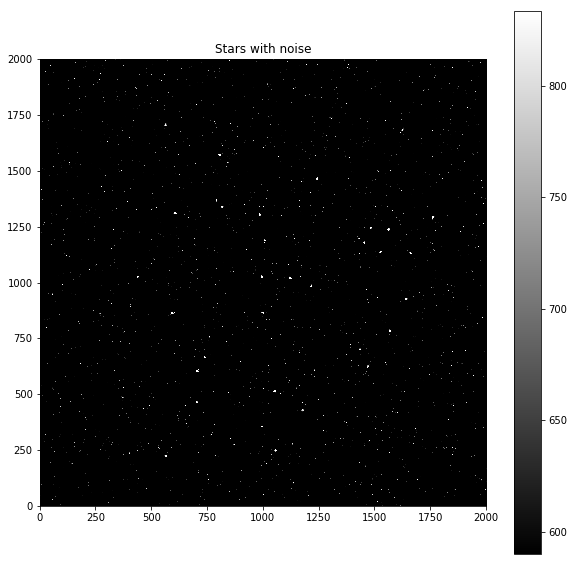

In [12]:
image = np.zeros([2000, 2000])
gain = 1.0
noise_amount = 500 

stars_with_noise = imsim.stars(image, 50, max_counts=2000) + imsim.read_noise(image, noise_amount, gain=gain)

show_image(stars_with_noise, cmap='gray', percu=99.9)
plt.title('Stars with noise')

### Now an *incorrect* attempt at removing noise

Notice that the call to the noise function has exactly the same arguments as above, in much the same way your canera's electronics will have the same noise properties every time you read out an image.

However, the amount of noise has **increased**, not decreased. It is much harder to pick out the stars in this image.

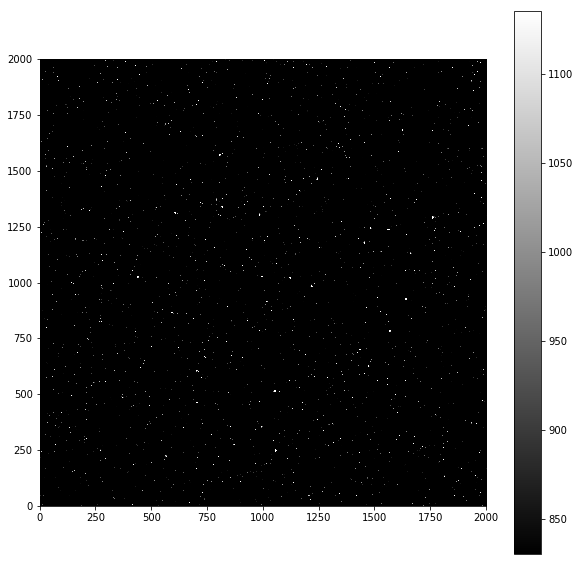

In [13]:
incorrect_attempt_to_remove_noise = stars_with_noise - imsim.read_noise(image, noise_amount, gain=gain)

show_image(incorrect_attempt_to_remove_noise, cmap='gray', percu=99.9)

## Every image has noise

Every image, including calibration images like bias and dark frames, has noise. If one were to try to calibrate images by taking a single bias image and a single dark image the final result might well look worse than before the image is reduced.

For the sake of completeness, we'll see what happens below.

Note that here we construct *realistic* bias and dark, but leave read noise out of the flat; we'll return to that point later. 

### First, set parameters for the CCD

These are the same as in the previous notebook, except for the read noise, which is 100 times larger.

In [14]:
gain = 1.0
exposure = 30.0
dark = 0.1
sky_counts = 20
bias_level = 1100
read_noise_electrons = 500
max_star_counts = 2000

### Generate the images, with noise

In [17]:
bias_with_noise = (imsim.bias(image, bias_level, realistic=True) + 
                   imsim.read_noise(image, read_noise_electrons, gain=gain))
dark_with_noise = (imsim.dark_current(image, dark, exposure, gain=gain, hot_pixels=True) +
                   imsim.read_noise(image, read_noise_electrons, gain=gain))

flat = imsim.sensitivity_variations(image)

## Uh oh...

this seemed like a birght idea at first, but now I'm having regrets about notation, at a minimum. The issue is that what I've been calling dark, e.g., is really just dark current. A dark image would have bias also.

Maybe it is enough to just stick with the first example in this notebook, or to do an "ideal" case.